In [1]:
import mysql.connector
import os
from dotenv import load_dotenv
from mysql.connector import Error

import pandas as pd

In [7]:
def get_data_from_db(table_name, columns = '*'):
    
    # dot env
    load_dotenv()
    aws_db_ufo_pw = os.getenv('aws_db_ufo_pw')
    aws_host_ufo = os.getenv('aws_host_ufo')

    remote = mysql.connector.connect(
        host = aws_host_ufo,
        user = 'EDA',
        port = 3306,  # default 는 3306
        password = aws_db_ufo_pw,
        database = 'Frisbee'

        )
        
    

    cursor = remote.cursor(dictionary = True)
    
    
    query = f"""
        SELECT {columns} FROM {table_name}"""
    
    cursor.execute(query)
    
    results = cursor.fetchall()

    
    
    column_name = [des[0] for des in cursor.description]
    
    cursor.close()
    
    df = pd.DataFrame.from_records(results, index = column_name[0])
    
    
    return df

In [12]:
if __name__ == '__main__':
    df = get_data_from_db('UFO_us')

In [9]:
df

,date,time,city,state,shape,duration,comments,latitude,longitude
id,,,,,,,,,
1190,1995-01-01,0 days,el granada,ca,fireball,45,Glowing fireball object crashed at Maverick&#...,37.5028,-122.4680
1191,1995-01-01,0 days,cedar key,fl,triangle,180,I could hear and see it&#44 close encounter.,29.1383,-83.0353
1192,1995-01-01,0 days,greenwood,sc,sphere,20,Bright red sphere floating and completely sile...,34.1953,-82.1619
1193,1995-01-01,0 days,tucson,az,triangle,600,120-140 ft&#44 X 35-40 ft&#44 X 30 ft&#44 tria...,32.2217,-110.9260
1194,1995-01-01,0 days,pacific grove,ca,unknown,0,Rept. that local police had pursued a strange ...,36.6178,-121.9160
...,...,...,...,...,...,...,...,...,...
66135,2014-05-07,0 days,port richey,fl,unknown,1,Sonic boom denied by military source per McDil...,28.2714,-82.7197
66136,2014-05-07,0 days,calera,al,circle,240,Orange/red sphere with blue or green outline o...,33.1028,-86.7536
66137,2014-05-07,0 days,detroit,mi,fireball,180,Fire balls in detroit sky.,42.3314,-83.0458


In [13]:
df.to_csv('/Users/sungminhong/Documents/dev_ws/ufo_eda/data/ufo/ufo_us.csv')

### 날짜별 관측 횟수

In [42]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool
from bokeh.plotting import output_file
from bokeh.models import ColumnDataSource

#### 데이터 전처리

In [16]:
df['date'] = pd.to_datetime(df['date'], errors = 'coerce')
# 강제로 처리): 만약 'date' 컬럼의 값 중 "1995-01-01"처럼 정상적인 날짜가 아니라 
# "날짜모름" 또는 "1995/??/!!" 같은 인식 불가능한 텍스트가 있더라도, 오류를 발생시키며 
# 프로그램을 멈추지 말고, 대신 그 값을 NaT (Not a Time, "시간 아님"이라는 뜻의 결측치)로 
# 강제로 변환하라는 의미

In [19]:
df = df.reset_index()

In [21]:
df['id'] = df.index

In [23]:
# 날짜 변환에 실패한 (NaT) 행이 있는지 확인하고 제거
original_count = len(df)
df.dropna(subset=['date'], inplace=True)
dropped_count = original_count - len(df)
if dropped_count > 0:
    print(f"{dropped_count}개의 유효하지 않은 날짜 행 제거됨.")

# 'date' 컬럼을 인덱스로 설정
df.set_index('date', inplace=True)

# 월별로 데이터 집계 (목격 횟수 카운트)
# 'M'은 Month End (월말) 기준입니다.
df_monthly = df.resample('M')['id'].count().reset_index()
df_monthly.columns = ['date', 'sightings']

print("월별 데이터 집계 완료.")
print(df_monthly.head())

월별 데이터 집계 완료.
        date  sightings
0 1995-01-31        162
1 1995-02-28        200
2 1995-03-31        206
3 1995-04-30        154
4 1995-05-31        176


/var/folders/kh/6khx28zs2bq8wjptklpbkj440000gn/T/ipykernel_72403/3174135641.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df.resample('M')['id'].count().reset_index()


### visualize

In [24]:
# HoverTool 설정 (마우스를 올렸을 때 보일 정보)
    

hover = HoverTool(tooltips=[
    ('날짜', '@date{%Y-%m}'),  # 날짜 포맷 지정
    ('목격 횟수', '@sightings')
], formatters={'@date': 'datetime'}) # @date 필드를 datetime으로 포맷

# Bokeh Figure 생성
p = figure(
    title='월별 UFO 목격 횟수 (Bokeh)',
    x_axis_label='날짜',
    y_axis_label='목격 횟수',
    x_axis_type='datetime',  # X축을 날짜/시간 타입으로 설정
    width=800,
    height=400,
    tools=[hover, 'pan', 'wheel_zoom', 'box_zoom', 'reset', 'save'] # 인터랙티브 툴 추가
)

# 라인 그래프 추가 (전처리된 df_monthly를 source로 직접 사용)
p.line(x='date', y='sightings', source=df_monthly, line_width=2, color='navy', alpha=0.8)

# 그리드 라인 투명도 조절
p.xgrid.grid_line_alpha = 0.3
p.ygrid.grid_line_alpha = 0.3

# 그래프 보여주기 
# (Jupyter가 아니면 새 브라우저 탭에서 열립니다)
show(p)


### 지역별 발견 빈도 분석

#### 전처리

In [25]:
df

,time,city,state,shape,duration,comments,latitude,longitude,id
date,,,,,,,,,
1995-01-01,0 days,el granada,ca,fireball,45,Glowing fireball object crashed at Maverick&#...,37.5028,-122.4680,0
1995-01-01,0 days,cedar key,fl,triangle,180,I could hear and see it&#44 close encounter.,29.1383,-83.0353,1
1995-01-01,0 days,greenwood,sc,sphere,20,Bright red sphere floating and completely sile...,34.1953,-82.1619,2
1995-01-01,0 days,tucson,az,triangle,600,120-140 ft&#44 X 35-40 ft&#44 X 30 ft&#44 tria...,32.2217,-110.9260,3
1995-01-01,0 days,pacific grove,ca,unknown,0,Rept. that local police had pursued a strange ...,36.6178,-121.9160,4
...,...,...,...,...,...,...,...,...,...
2014-05-07,0 days,port richey,fl,unknown,1,Sonic boom denied by military source per McDil...,28.2714,-82.7197,64945
2014-05-07,0 days,calera,al,circle,240,Orange/red sphere with blue or green outline o...,33.1028,-86.7536,64946
2014-05-07,0 days,detroit,mi,fireball,180,Fire balls in detroit sky.,42.3314,-83.0458,64947


In [28]:
state_name_map = {
    'al': 'Alabama', 'ak': 'Alaska', 'az': 'Arizona', 'ar': 'Arkansas', 'ca': 'California',
    'co': 'Colorado', 'ct': 'Connecticut', 'de': 'Delaware', 'fl': 'Florida', 'ga': 'Georgia',
    'hi': 'Hawaii', 'id': 'Idaho', 'il': 'Illinois', 'in': 'Indiana', 'ia': 'Iowa',
    'ks': 'Kansas', 'ky': 'Kentucky', 'la': 'Louisiana', 'me': 'Maine', 'md': 'Maryland',
    'ma': 'Massachusetts', 'mi': 'Michigan', 'mn': 'Minnesota', 'ms': 'Mississippi', 'mo': 'Missouri',
    'mt': 'Montana', 'ne': 'Nebraska', 'nv': 'Nevada', 'nh': 'New Hampshire', 'nj': 'New Jersey',
    'nm': 'New Mexico', 'ny': 'New York', 'nc': 'North Carolina', 'nd': 'North Dakota', 'oh': 'Ohio',
    'ok': 'Oklahoma', 'or': 'Oregon', 'pa': 'Pennsylvania', 'ri': 'Rhode Island', 'sc': 'South Carolina',
    'sd': 'South Dakota', 'tn': 'Tennessee', 'tx': 'Texas', 'ut': 'Utah', 'vt': 'Vermont',
    'va': 'Virginia', 'wa': 'Washington', 'wv': 'West Virginia', 'wi': 'Wisconsin', 'wy': 'Wyoming',
    'dc': 'District of Columbia', 'pr': 'Puerto Rico'
}

In [29]:
# 주 약어 -> 지역 (서부, 중부, 동부) 매핑
state_region_map = {
    # 동부 (East)
    'me': '동부', 'nh': '동부', 'vt': '동부', 'ma': '동부', 'ri': '동부', 'ct': '동부', 'ny': '동부',
    'nj': '동부', 'pa': '동부', 'de': '동부', 'md': '동부', 'dc': '동부', 'wv': '동부', 'va': '동부',
    'nc': '동부', 'sc': '동부', 'ga': '동부', 'fl': '동부',
    # 중부 (Central)
    'oh': '중부', 'mi': '중부', 'in': '중부', 'il': '중부', 'wi': '중부', 'mn': '중부', 'ia': '중부',
    'mo': '중부', 'nd': '중부', 'sd': '중부', 'ne': '중부', 'ks': '중부', 'ky': '중부', 'tn': '중부',
    'al': '중부', 'ms': '중부', 'ar': '중부', 'la': '중부', 'ok': '중부', 'tx': '중부',
    # 서부 (West)
    'mt': '서부', 'wy': '서부', 'co': '서부', 'nm': '서부', 'az': '서부', 'ut': '서부', 'nv': '서부',
    'id': '서부', 'wa': '서부', 'or': '서부', 'ca': '서부', 'ak': '서부', 'hi': '서부',
    # 기타
    'pr': '기타'
}

In [30]:
df['state_name'] = df['state'].map(state_name_map).fillna('Unknown')
df['region'] = df['state'].map(state_region_map).fillna('Unknown')

In [31]:
df

,time,city,state,shape,duration,comments,latitude,longitude,id,state_name,region
date,,,,,,,,,,,
1995-01-01,0 days,el granada,ca,fireball,45,Glowing fireball object crashed at Maverick&#...,37.5028,-122.4680,0,California,서부
1995-01-01,0 days,cedar key,fl,triangle,180,I could hear and see it&#44 close encounter.,29.1383,-83.0353,1,Florida,동부
1995-01-01,0 days,greenwood,sc,sphere,20,Bright red sphere floating and completely sile...,34.1953,-82.1619,2,South Carolina,동부
1995-01-01,0 days,tucson,az,triangle,600,120-140 ft&#44 X 35-40 ft&#44 X 30 ft&#44 tria...,32.2217,-110.9260,3,Arizona,서부
1995-01-01,0 days,pacific grove,ca,unknown,0,Rept. that local police had pursued a strange ...,36.6178,-121.9160,4,California,서부
...,...,...,...,...,...,...,...,...,...,...,...
2014-05-07,0 days,port richey,fl,unknown,1,Sonic boom denied by military source per McDil...,28.2714,-82.7197,64945,Florida,동부
2014-05-07,0 days,calera,al,circle,240,Orange/red sphere with blue or green outline o...,33.1028,-86.7536,64946,Alabama,중부
2014-05-07,0 days,detroit,mi,fireball,180,Fire balls in detroit sky.,42.3314,-83.0458,64947,Michigan,중부


In [32]:
shape_category_map = {
    # 원형/구형 (Round/Spherical)
    'circle': '원형/구형', 'sphere': '원형/구형', 'oval': '원형/구형', 'disk': '원형/구형',
    'egg': '원형/구형', 'teardrop': '원형/구형', 'round': '원형/구형',
    
    # 빛/광선 (Light Phenomena)
    'light': '빛/광선', 'fireball': '빛/광선', 'flash': '빛/광선', 'flare': '빛/광선',
    
    # 삼각형 (Triangular)
    'triangle': '삼각형', 'delta': '삼각형', 'chevron': '삼각형', 'pyramid': '삼각형',
    
    # 기하학적 (Geometric - Non-round)
    'rectangle': '기하학적', 'cylinder': '기하학적', 'cigar': '기하학적', 'diamond': '기하학적',
    'cone': '기하학적', 'cross': '기하학적', 'hexagon': '기하학적', 'crescent': '기하학적',
    
    # 기타/불명확 (Other/Ambiguous)
    'unknown': '기타/불명확', 'other': '기타/불명확', 'formation': '기타/불명확',
    'changing': '기타/불명확', 'changed': '기타/불명확'
}

In [34]:
# .map()을 사용하여 카테고리 열 생성
df['shape_category'] = df['shape'].map(shape_category_map)
df['shape_category'] = df['shape_category'].fillna('기타/불명확')

In [35]:
df

,time,city,state,shape,duration,comments,latitude,longitude,id,state_name,region,shape_category
date,,,,,,,,,,,,
1995-01-01,0 days,el granada,ca,fireball,45,Glowing fireball object crashed at Maverick&#...,37.5028,-122.4680,0,California,서부,빛/광선
1995-01-01,0 days,cedar key,fl,triangle,180,I could hear and see it&#44 close encounter.,29.1383,-83.0353,1,Florida,동부,삼각형
1995-01-01,0 days,greenwood,sc,sphere,20,Bright red sphere floating and completely sile...,34.1953,-82.1619,2,South Carolina,동부,원형/구형
1995-01-01,0 days,tucson,az,triangle,600,120-140 ft&#44 X 35-40 ft&#44 X 30 ft&#44 tria...,32.2217,-110.9260,3,Arizona,서부,삼각형
1995-01-01,0 days,pacific grove,ca,unknown,0,Rept. that local police had pursued a strange ...,36.6178,-121.9160,4,California,서부,기타/불명확
...,...,...,...,...,...,...,...,...,...,...,...,...
2014-05-07,0 days,port richey,fl,unknown,1,Sonic boom denied by military source per McDil...,28.2714,-82.7197,64945,Florida,동부,기타/불명확
2014-05-07,0 days,calera,al,circle,240,Orange/red sphere with blue or green outline o...,33.1028,-86.7536,64946,Alabama,중부,원형/구형
2014-05-07,0 days,detroit,mi,fireball,180,Fire balls in detroit sky.,42.3314,-83.0458,64947,Michigan,중부,빛/광선


#### visualize

In [44]:
from bokeh.palettes import Category10_4

In [46]:
# df['date'] = pd.to_datetime(df['date'], errors='coerce')

# # 유효하지 않은 날짜(NaT) 행 제거
# df.dropna(subset=['date'], inplace=True)

# 시계열 분석을 위해 날짜를 인덱스로 설정
# df.set_index('date', inplace=True)

# print("데이터 전처리 완료 (지역 분류 및 날짜 변환).")

# -----------------------------------------------------------------
# 2. 다중 라인 플롯을 위한 데이터 집계 (Aggregation)
# -----------------------------------------------------------------
print("월별, 지역별 데이터 집계 중...")

# [핵심] region(지역)별로 그룹화한 뒤, 월('M') 단위로 리샘플링하여 횟수 집계
#       unstack(): 'region' 인덱스를 컬럼으로 변환 (pivot)
#       fill_value=0: 특정 월에 해당 지역 데이터가 없으면 0으로 채움
df_agg = df.groupby('region').resample('M')['id'].count().unstack(level='region', fill_value=0)

# 요청한 '미국 전체' 열 추가 (동부 + 중부 + 서부)
# '기타'와 'Unknown'은 제외하여 세 지역만 합산
df_agg['Total'] = df_agg['동부'] + df_agg['중부'] + df_agg['서부']

# Bokeh에 사용하기 위해 인덱스(date)를 컬럼으로 리셋
df_agg_final = df_agg[['Total', '동부', '중부', '서부']].reset_index()

# ColumnDataSource로 변환
source = ColumnDataSource(df_agg_final)

print("데이터 집계 완료. Bokeh 플롯 생성 중...")

# -----------------------------------------------------------------
# 3. Bokeh 다중 라인 시각화
# -----------------------------------------------------------------

# (Jupyter Notebook/Lab 환경일 경우 주석 해제)
# output_notebook() 

# 결과를 HTML 파일로 저장
output_file("ufo_sightings_by_region.html")

# HoverTool 설정
# mode='vline': 마우스 X축(날짜) 기준으로 수직선을 그리고, 그 선에 닿는 모든 라인의 정보를 표시
hover = HoverTool(
    tooltips=[
        ('날짜', '@date{%Y-%m}'),
        ('전체', '@Total'),
        ('서부', '@서부'),
        ('중부', '@중부'),
        ('동부', '@동부'),
    ],
    formatters={'@date': 'datetime'},
    mode='vline' # 수직선 모드
)

# Bokeh Figure 생성
p = figure(
    title='월별 UFO 목격 횟수 (지역별)',
    x_axis_label='날짜',
    y_axis_label='목격 횟수',
    x_axis_type='datetime',
    width=900,
    height=450,
    tools=[hover, 'pan', 'wheel_zoom', 'box_zoom', 'reset', 'save'] # hover 툴 추가
)

# 다중 라인 그래프 그리기
# (Category10_4 팔레트 사용: [blue, orange, green, red])
colors = Category10_4

# 1. 미국 전체 (Total) - 검은색으로 굵게
p.line(x='date', y='Total', source=source, line_width=3, color='grey', 
       alpha=0.4, legend_label='미국 전체')

# 2. 서부 (West)
p.line(x='date', y='서부', source=source, line_width=2, color=colors[0], 
       alpha=0.8, legend_label='서부')

# 3. 중부 (Central)
p.line(x='date', y='중부', source=source, line_width=2, color=colors[1], 
       alpha=0.8, legend_label='중부')

# 4. 동부 (East)
p.line(x='date', y='동부', source=source, line_width=2, color=colors[2], 
       alpha=0.8, legend_label='동부')


# 그리드 라인 투명도 조절
p.xgrid.grid_line_alpha = 0.3
p.ygrid.grid_line_alpha = 0.3

# 범례(Legend) 설정
p.legend.location = "top_left"
p.legend.click_policy = "hide" # 범례 클릭 시 해당 라인 숨기기/보이기

# 그래프 보여주기 (브라우저 새 탭 또는 HTML 파일 생성)
show(p)

월별, 지역별 데이터 집계 중...
데이터 집계 완료. Bokeh 플롯 생성 중...


/var/folders/kh/6khx28zs2bq8wjptklpbkj440000gn/T/ipykernel_72403/2158131737.py:19: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_agg = df.groupby('region').resample('M')['id'].count().unstack(level='region', fill_value=0)


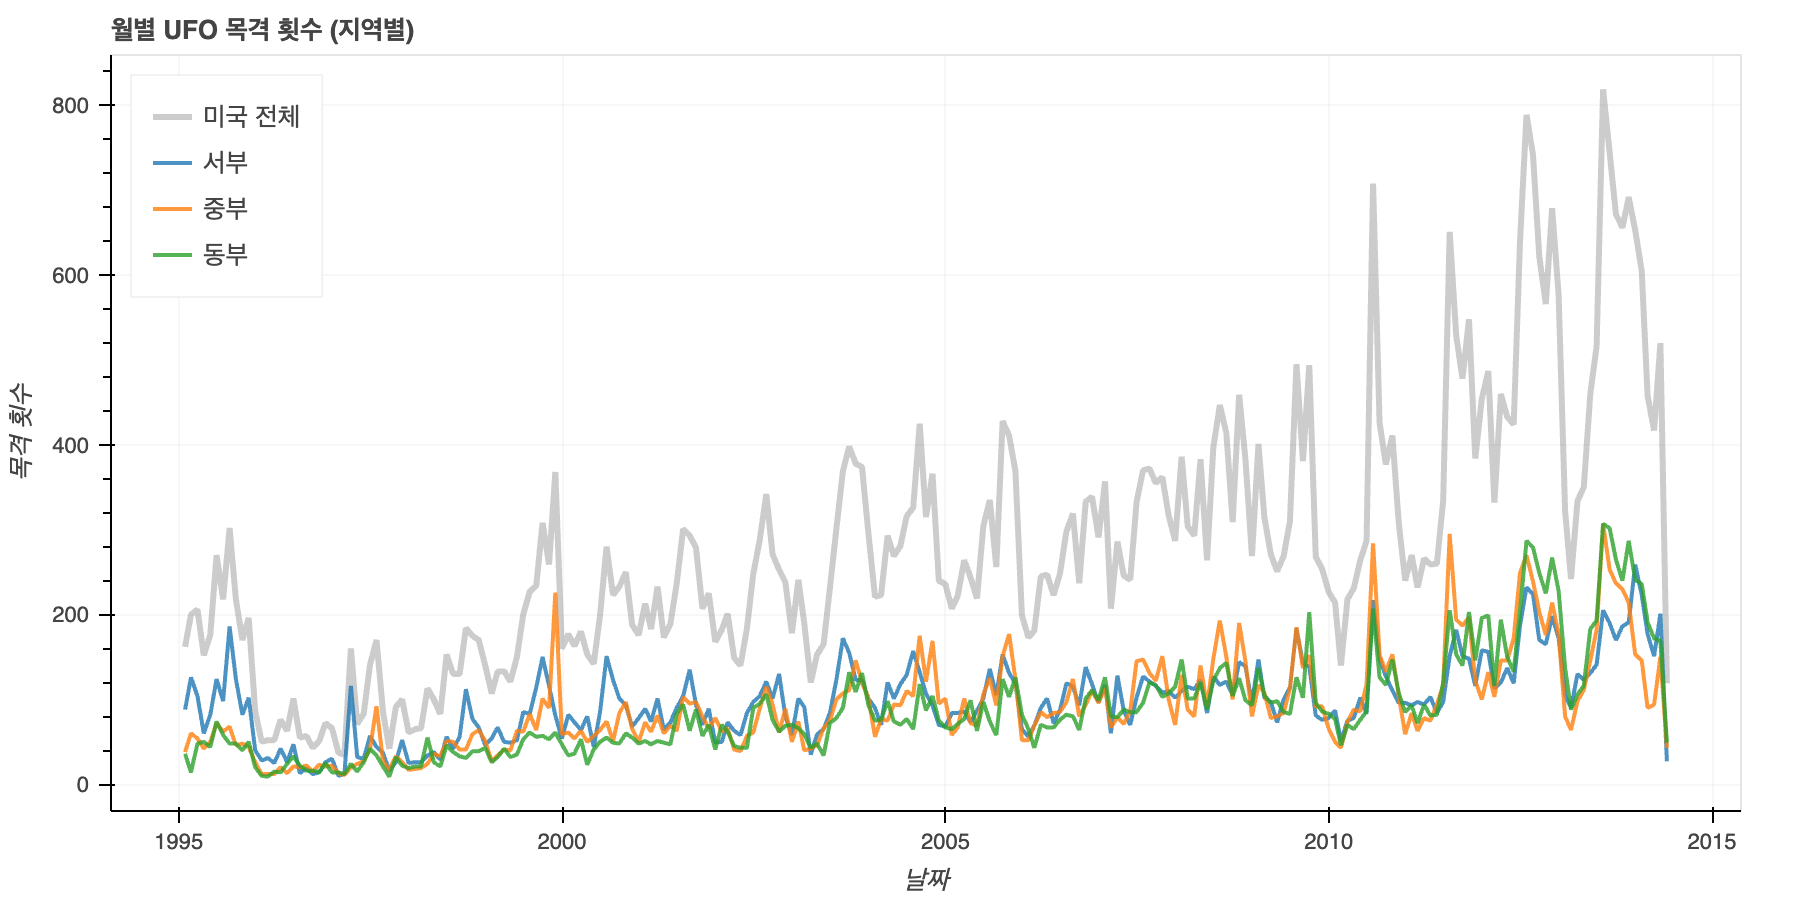

In [47]:
df

,time,city,state,shape,duration,comments,latitude,longitude,id,state_name,region,shape_category
date,,,,,,,,,,,,
1995-01-01,0 days,el granada,ca,fireball,45,Glowing fireball object crashed at Maverick&#...,37.5028,-122.4680,0,California,서부,빛/광선
1995-01-01,0 days,cedar key,fl,triangle,180,I could hear and see it&#44 close encounter.,29.1383,-83.0353,1,Florida,동부,삼각형
1995-01-01,0 days,greenwood,sc,sphere,20,Bright red sphere floating and completely sile...,34.1953,-82.1619,2,South Carolina,동부,원형/구형
1995-01-01,0 days,tucson,az,triangle,600,120-140 ft&#44 X 35-40 ft&#44 X 30 ft&#44 tria...,32.2217,-110.9260,3,Arizona,서부,삼각형
1995-01-01,0 days,pacific grove,ca,unknown,0,Rept. that local police had pursued a strange ...,36.6178,-121.9160,4,California,서부,기타/불명확
...,...,...,...,...,...,...,...,...,...,...,...,...
2014-05-07,0 days,port richey,fl,unknown,1,Sonic boom denied by military source per McDil...,28.2714,-82.7197,64945,Florida,동부,기타/불명확
2014-05-07,0 days,calera,al,circle,240,Orange/red sphere with blue or green outline o...,33.1028,-86.7536,64946,Alabama,중부,원형/구형
2014-05-07,0 days,detroit,mi,fireball,180,Fire balls in detroit sky.,42.3314,-83.0458,64947,Michigan,중부,빛/광선


In [48]:
df_agg

region,기타,동부,서부,중부,Total
date,,,,,
1995-01-31,0,36,88,38,162
1995-02-28,0,14,126,60,200
1995-03-31,0,48,104,54,206
1995-04-30,2,50,60,42,152
1995-05-31,0,44,82,50,176
...,...,...,...,...,...
2014-01-31,0,236,223,146,605
2014-02-28,0,191,177,90,458
2014-03-31,0,172,151,94,417


In [88]:
import numpy as np # (x, y) 좌표 계산을 위해 numpy 추가
from math import pi 
from bokeh.plotting import figure, show, output_file
from bokeh.models import ColumnDataSource, HoverTool, LabelSet # [수정] LabelSet 추가
from bokeh.palettes import Spectral5 # [수정] Category10_5 대신 Spectral5 사용
from bokeh.transform import factor_cmap

In [97]:
df_counts = df['shape_category'].value_counts().reset_index()
df_counts.columns = ['category', 'count']

category_col_name = df_counts.columns[0] # 첫 번째 컬럼 (카테고리 이름)
count_col_name = df_counts.columns[1]    # 두 번째 컬럼 (횟수)

In [98]:
df_counts['angle'] = df_counts['count'] / df_counts['count'].sum() * 2 * pi

df_counts['percent_str'] = df_counts['count'] / df_counts['count'].sum() * 100

cmap_factors = df_counts['category'].tolist()

source = ColumnDataSource(df_counts)

In [99]:
df_counts

,category,count,angle,percent_str
0,빛/광선,19933,1.928295,30.689761
1,원형/구형,17608,1.703377,27.110085
2,기타/불명확,15462,1.495775,23.806005
3,삼각형,7140,0.690715,10.993072
4,기하학적,4807,0.465023,7.401078


In [132]:
df_counts['angle'] = df_counts['count'] / df_counts['count'].sum() * 2 * pi

df_counts['percent_str'] = (df_counts['count'] / df_counts['count'].sum() * 100).round(2).astype(str) + '%'

cmap_factors = df_counts['category'].tolist()

source = ColumnDataSource(df_counts)


df_counts['start_angle'] = df_counts['angle'].cumsum().shift(1).fillna(0)
df_counts['end_angle'] = df_counts['angle'].cumsum()
df_counts['mid_angle'] = df_counts['start_angle'] + (df_counts['angle'] / 2) # 텍스트를 중간 각도에 배치

text_radius = 1.05
# 중간 각도와 반지름을 사용해 (x, y) 좌표 계산
df_counts['x'] = np.cos(df_counts['mid_angle']) * text_radius
df_counts['y'] = np.sin(df_counts['mid_angle']) * text_radius

source = ColumnDataSource(df_counts)

output_file("ufo_donut_chart_by_shape.html")

# HoverTool 설정 (카테고리, 횟수, 퍼센트 표시)
hover = HoverTool(tooltips=[
    ("모양", f"@{category_col_name}"), 
    ("횟수", f"@{count_col_name}"),  
    ("비율", "@percentage_str") # 수정된 컬럼명 참조
])

# Bokeh Figure 생성 (사용자 요청: height=700)
p = figure(
    title='UFO 목격 모양 비율 (도넛 차트)',
    width=700,
    height=700, # 사용자 요청 반영
    tools=[hover, 'pan', 'wheel_zoom', 'reset', 'save'], 
    toolbar_location="right",
    x_range=(-1.2, 1.2), 
    y_range=(-1.2, 1.2)
)

p.title.text_font_size = '16pt'
p.title.text_font = 'Helvetica'
p.title.text_font_style = 'bold'
p.title.text_color = 'dimgray'

p.background_fill_color = "whitesmoke"



# [핵심] 도넛 차트(Annular Wedge) 그리기
p.annular_wedge(
    x=0, y=0,                  
    inner_radius=0.6,          
    outer_radius=0.9,          
    source=source,             
    
    start_angle='start_angle', # 미리 계산된 컬럼 사용
    end_angle='end_angle',     # 미리 계산된 컬럼 사용
    
    # ▼▼▼ [오류 수정] ▼▼▼
    # 'category_col_name' (문자열) 대신 category_col_name (변수) 사용
    color=factor_cmap(category_col_name, palette=Spectral5, factors=cmap_factors),
    
    # legend_field도 동적 컬럼명 사용
    legend_field=category_col_name,   
    
    line_color="white",        
    line_width=2               
)

# [추가] 퍼센트(%) 텍스트 레이블 (수정된 'percentage_str' 컬럼 참조)
labels = LabelSet(
    x='x', 
    y='y', 
    text='percent_str', # 표시할 텍스트
    source=source,
    text_color='dimgray',
    text_font_size='15pt',
    text_align='center',    
    text_baseline='middle',
    text_font = 'Helvetica',
    text_font_style='bold'  
)
p.add_layout(labels) # Figure에 레이블 추가

# 차트 꾸미기
p.axis.visible = False          
p.grid.visible = False

p.legend.location = "center" 
p.legend.label_text_font_size = '15pt'
p.legend.background_fill_color = "whitesmoke"
p.legend.border_line_color = None
# 그래프 보여주기
show(p)

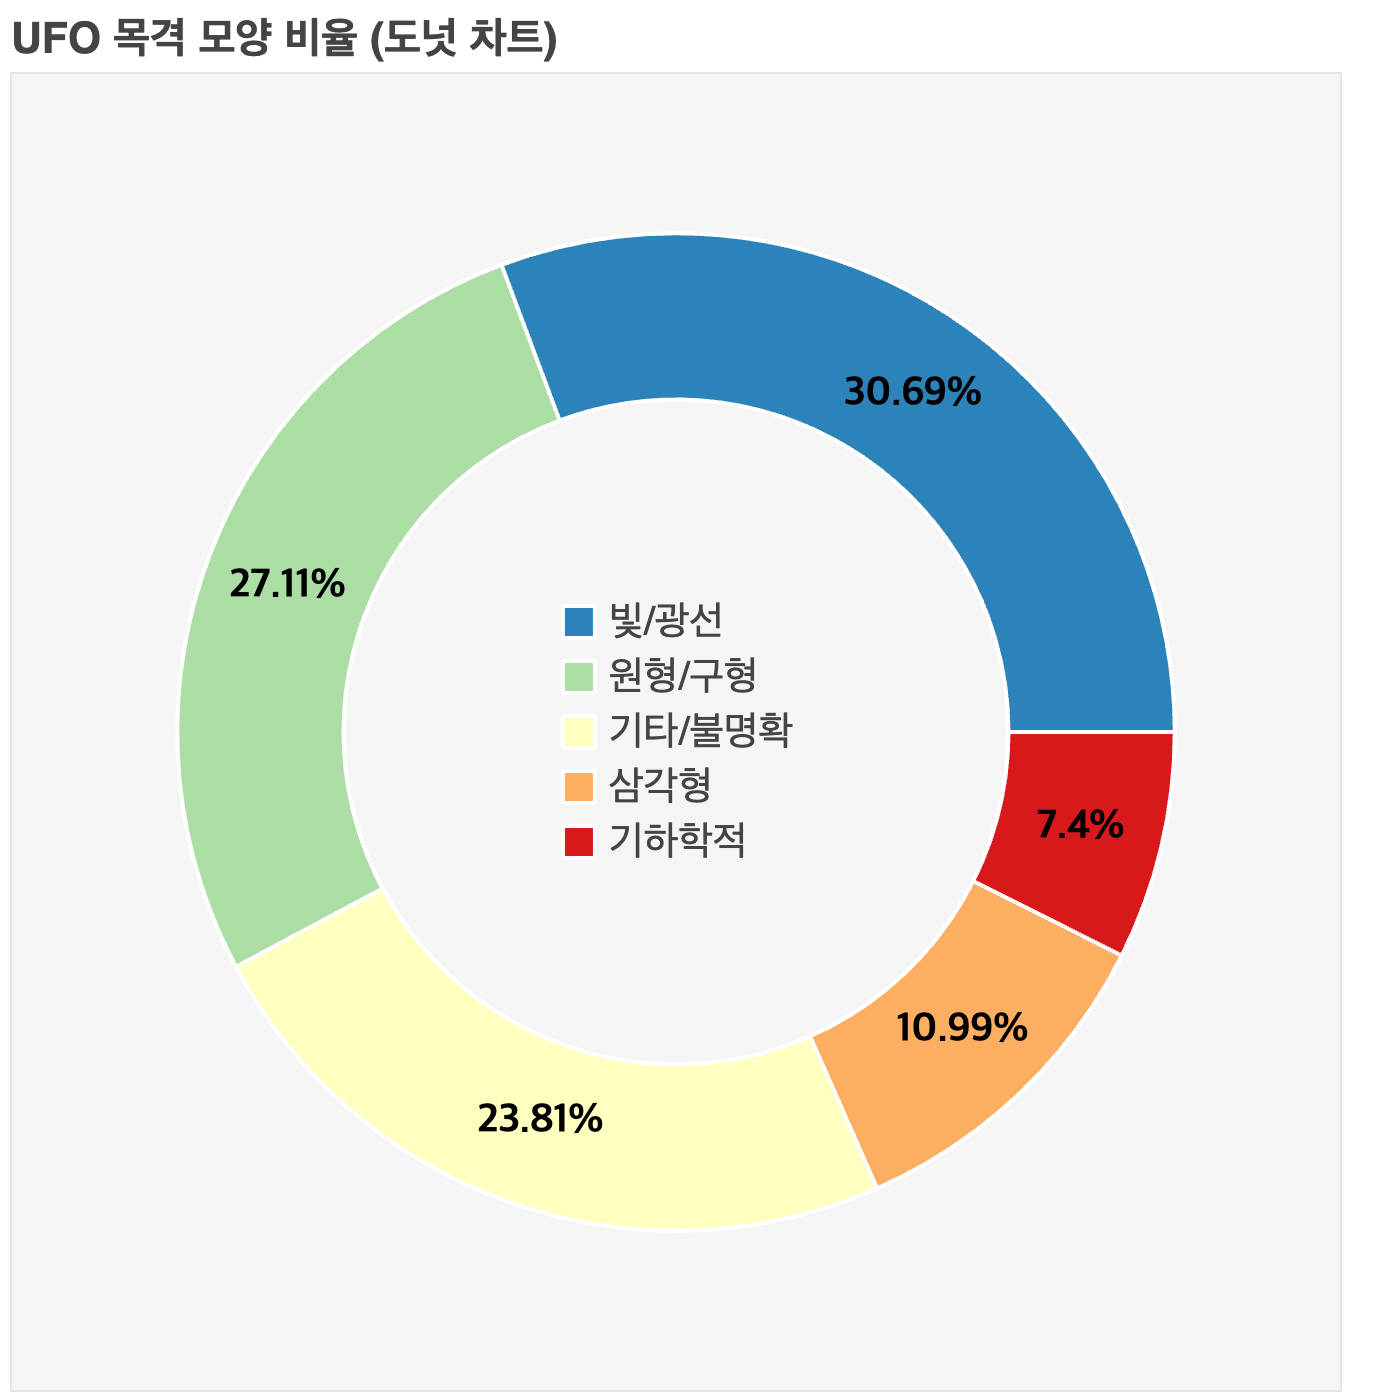

In [150]:
from bokeh.models import ColumnDataSource
from bokeh.palettes import Bright6
from bokeh.plotting import figure, show
import plotly.express as px
# address 열에서 state 데이터 추출이 어려운 데이터 확인

In [151]:
df

,index,date,time,city,state,shape,duration,comments,latitude,longitude,id,state_name,region,shape_category
0,0,1995-01-01,0 days,el granada,ca,fireball,45,Glowing fireball object crashed at Maverick&#...,37.5028,-122.4680,0,California,서부,빛/광선
1,1,1995-01-01,0 days,cedar key,fl,triangle,180,I could hear and see it&#44 close encounter.,29.1383,-83.0353,1,Florida,동부,삼각형
2,2,1995-01-01,0 days,greenwood,sc,sphere,20,Bright red sphere floating and completely sile...,34.1953,-82.1619,2,South Carolina,동부,원형/구형
3,3,1995-01-01,0 days,tucson,az,triangle,600,120-140 ft&#44 X 35-40 ft&#44 X 30 ft&#44 tria...,32.2217,-110.9260,3,Arizona,서부,삼각형
4,4,1995-01-01,0 days,pacific grove,ca,unknown,0,Rept. that local police had pursued a strange ...,36.6178,-121.9160,4,California,서부,기타/불명확
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64945,64945,2014-05-07,0 days,port richey,fl,unknown,1,Sonic boom denied by military source per McDil...,28.2714,-82.7197,64945,Florida,동부,기타/불명확
64946,64946,2014-05-07,0 days,calera,al,circle,240,Orange/red sphere with blue or green outline o...,33.1028,-86.7536,64946,Alabama,중부,원형/구형
64947,64947,2014-05-07,0 days,detroit,mi,fireball,180,Fire balls in detroit sky.,42.3314,-83.0458,64947,Michigan,중부,빛/광선
64948,64948,2014-05-07,0 days,seagrove beach,fl,fireball,60,Around 8:30 pm I was on the balcony of our con...,30.3183,-86.1303,64948,Florida,동부,빛/광선


In [ ]:
df['log_duration'] = df['duration'].astype(int)

In [161]:
df

,level_0,index,date,time,city,state,shape,duration,comments,latitude,longitude,id,state_name,region,shape_category
0,0,0,1995-01-01,0 days,el granada,ca,fireball,45,Glowing fireball object crashed at Maverick&#...,37.5028,-122.4680,0,California,서부,빛/광선
1,1,1,1995-01-01,0 days,cedar key,fl,triangle,180,I could hear and see it&#44 close encounter.,29.1383,-83.0353,1,Florida,동부,삼각형
2,2,2,1995-01-01,0 days,greenwood,sc,sphere,20,Bright red sphere floating and completely sile...,34.1953,-82.1619,2,South Carolina,동부,원형/구형
3,3,3,1995-01-01,0 days,tucson,az,triangle,600,120-140 ft&#44 X 35-40 ft&#44 X 30 ft&#44 tria...,32.2217,-110.9260,3,Arizona,서부,삼각형
4,4,4,1995-01-01,0 days,pacific grove,ca,unknown,0,Rept. that local police had pursued a strange ...,36.6178,-121.9160,4,California,서부,기타/불명확
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64945,64945,64945,2014-05-07,0 days,port richey,fl,unknown,1,Sonic boom denied by military source per McDil...,28.2714,-82.7197,64945,Florida,동부,기타/불명확
64946,64946,64946,2014-05-07,0 days,calera,al,circle,240,Orange/red sphere with blue or green outline o...,33.1028,-86.7536,64946,Alabama,중부,원형/구형
64947,64947,64947,2014-05-07,0 days,detroit,mi,fireball,180,Fire balls in detroit sky.,42.3314,-83.0458,64947,Michigan,중부,빛/광선
64948,64948,64948,2014-05-07,0 days,seagrove beach,fl,fireball,60,Around 8:30 pm I was on the balcony of our con...,30.3183,-86.1303,64948,Florida,동부,빛/광선


In [152]:
df = df.reset_index()

In [162]:
non_zero_duration = df[df['duration'] > 0]['duration']
q1_value = non_zero_duration.quantile(0.25)

In [163]:
df.loc[df['duration'] == 0, 'duration'] = q1_value

In [174]:
df['log_duration'] = np.log(df['duration'])

In [198]:
df_state = df.groupby(by = 'state_name').count().sort_values(by = 'date', ascending = False)
top_10_state_list = df_state.head(10).index
fig = px.scatter_map(
                df,
                lat="latitude",
                lon="longitude",
                color='state',
                size="duration",
                opacity = 0.5,
                # color_continuous_scale=px.colors.cyclical.IceFire,
                size_max=100,
                zoom=2.5,
                width=1200,  # <-- 그래프 전체 가로 크기
                height=1200
                )
fig.show(renderer='browser')

In [ ]:
df_state = df.groupby(by = 'state_name').count().sort_values(by = 'date', ascending = False)
top_10_state_list = df_state.head(10).index
fig = px.scatter_map(
                df,
                lat="latitude",
                lon="longitude",
                color='state',
                size="duration",
                opacity = 0.5,
                # color_continuous_scale=px.colors.cyclical.IceFire,
                size_max=100,
                zoom=2.5,
                width=1200,  # <-- 그래프 전체 가로 크기
                height=1200
                )
fig.show(renderer='browser')

![newplot (2).png](<attachment:newplot (2).png>)

In [ ]:
df_ufo_top_10_list = df_state.head(10).index
df_ufo_bottom_10_list = df_state.tail(10).index


In [195]:
df_ufo_top_10 = df[df['state_name'].isin(df_ufo_top_10_list)]
df_ufo_bottom_10 = df[df['state_name'].isin(df_ufo_bottom_10_list)]


In [196]:

fig = px.scatter_map(
                df_ufo_top_10,
                lat="latitude",
                lon="longitude",
                color='state',
                size="duration",
                opacity = 0.5,
                # color_continuous_scale=px.colors.cyclical.IceFire,
                size_max=100,
                zoom=2.5,
                width=1200,  # <-- 그래프 전체 가로 크기
                height=1200
                )
fig.show(renderer='browser')

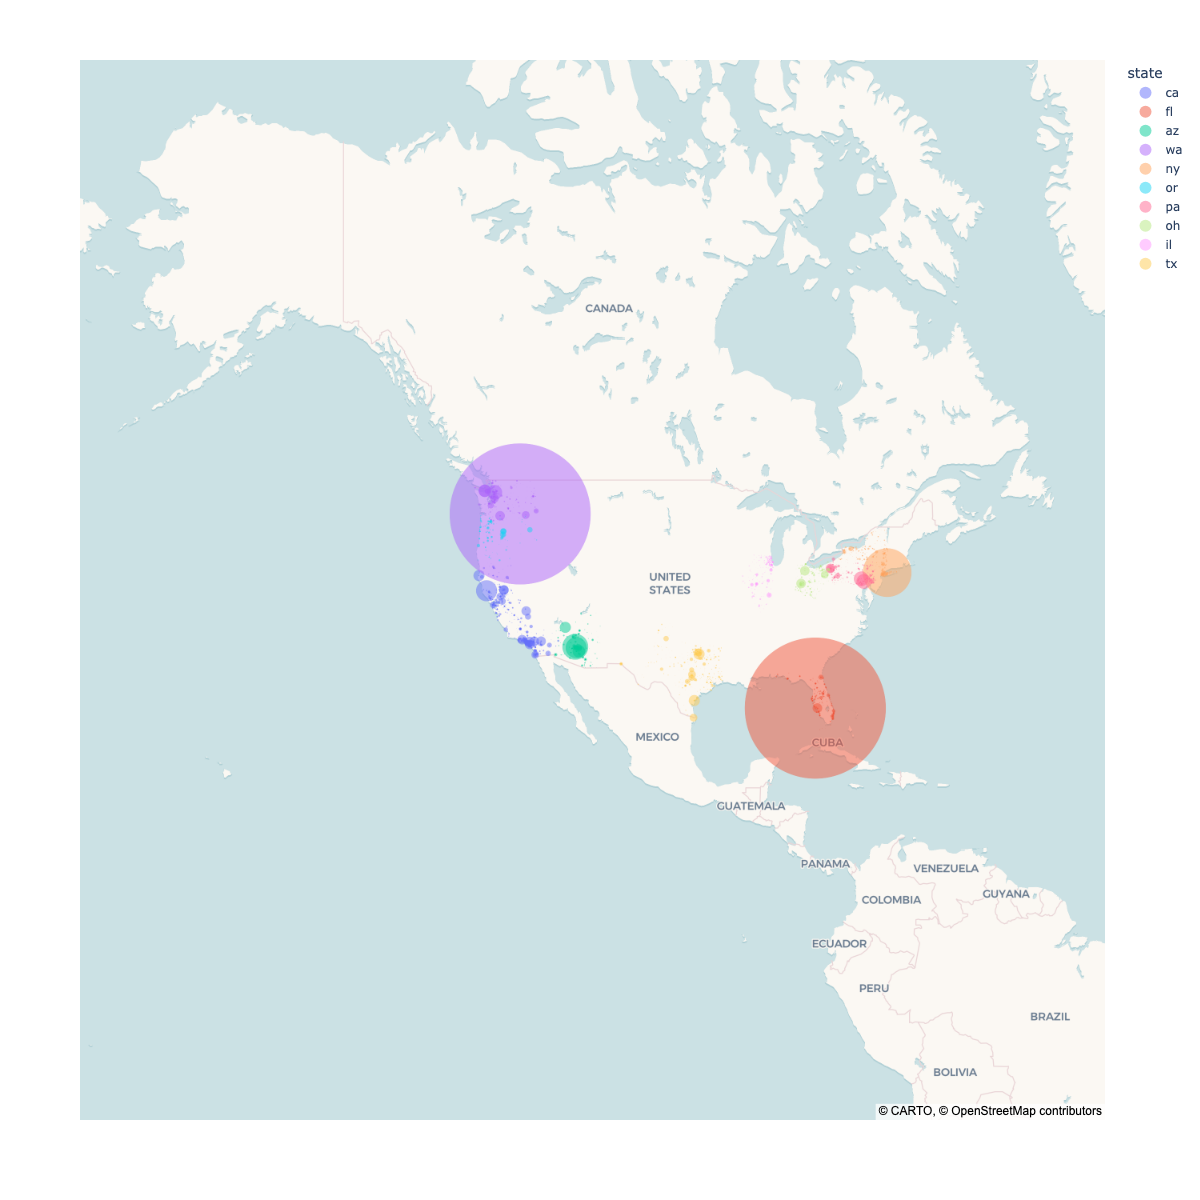

In [197]:
fig = px.scatter_map(
                df_ufo_bottom_10,
                lat="latitude",
                lon="longitude",
                color='state',
                size="duration",
                opacity = 0.5,
                # color_continuous_scale=px.colors.cyclical.IceFire,
                size_max=100,
                zoom=2.5,
                width=1200,  # <-- 그래프 전체 가로 크기
                height=1200
                )
fig.show(renderer='browser')

![newplot (1).png](<attachment:newplot (1).png>)